In [14]:
%pip install diffusers

   ---------------------------------------- 0.0/3.2 MB ? eta -:--:--
   ---------------------------------------- 3.2/3.2 MB 21.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [15]:
import random
import torch
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from diffusers import StableDiffusionInpaintPipeline

In [35]:
def add_inpainting_differences(
    pipe,
    image,
    num_differences=3,
    region_size_range=(50, 150),
    prompt="A subtle alteration in the masked region, preserving the original style",
    num_inference_steps=50,
    guidance_scale=7.5,
    generator=None
):
    """
    Applies inpainting to several randomly selected regions of the input image using the provided inpainting pipeline.
    
    Parameters:
      pipe (StableDiffusionInpaintPipeline): The inpainting pipeline.
      image (PIL.Image): The input art piece (assumed to be RGB and 512x512).
      num_differences (int): Number of regions to alter.
      region_size_range (tuple): (min, max) size for the rectangular regions.
      prompt (str): Text prompt to guide the inpainting. This prompt should instruct the model to make only a subtle change.
      num_inference_steps (int): Number of denoising steps.
      guidance_scale (float): Guidance scale for the model.
      generator (torch.Generator): A torch generator for reproducibility.
      
    Returns:
      modified_image (PIL.Image): The image after modifications.
      differences (list): List of tuples with region coordinates (x, y, width, height).
    """
    modified_image = image.copy()
    width, height = modified_image.size
    differences = []

    modified_images = []

    for i in range(num_differences):
        # Randomly determine the size of the region to modify.
        region_width = random.randint(region_size_range[0], region_size_range[1])
        region_height = random.randint(region_size_range[0], region_size_range[1])
        # Randomly choose the top-left corner ensuring the region fits within the image.
        x = random.randint(0, width - region_width)
        y = random.randint(0, height - region_height)
        differences.append((x, y, region_width, region_height))

        # Create a mask: white (255) where inpainting should occur, black (0) elsewhere.
        mask = Image.new("L", modified_image.size, 0)
        draw = ImageDraw.Draw(mask)
        draw.rectangle([x, y, x + region_width, y + region_height], fill=255)

        # Run the inpainting pipeline. The model will only modify the masked region.
        result = pipe(
            prompt=prompt,
            image=modified_image,
            mask_image=mask,
            num_inference_steps=num_inference_steps,
            guidance_scale=guidance_scale,
            generator=generator
        )
        # Use the resulting image as the new modified image.
        modified_image = result.images[0]

    return modified_image, differences

In [17]:
image_path = "Aertsen-3744dig-L.jpg"
try:
    original_image = Image.open(image_path).convert("RGB")
except Exception as e:
    print(f"Error loading image: {e}")

In [21]:
# Set up the inpainting pipeline.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [19]:
# Load the inpainting model from Hugging Face.
model_id = "runwayml/stable-diffusion-inpainting"
pipe = StableDiffusionInpaintPipeline.from_pretrained(model_id)
pipe = pipe.to(device)

# Set a random seed for reproducibility.
seed = 0
generator = torch.Generator(device=device).manual_seed(seed)

model_index.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/748 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.78k [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/492M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch C:\Users\victo\.cache\huggingface\hub\models--runwayml--stable-diffusion-inpainting\snapshots\8a4288a76071f7280aedbdb3253bdb9e9d5d84bb\vae: Error no file named diffusion_pytorch_model.safetensors found in directory C:\Users\victo\.cache\huggingface\hub\models--runwayml--stable-diffusion-inpainting\snapshots\8a4288a76071f7280aedbdb3253bdb9e9d5d84bb\vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch C:\Users\victo\.cache\huggingface\hub\models--runwayml--stable-diffusion-inpainting\snapshots\8a4288a76071f7280aedbdb3253bdb9e9d5d84bb\unet: Error no file named diffusion_pytorch_model.safetensors found in directory C:\Users\victo\.cache\huggingface\hub\models--runwayml--stable-diffusion-inpainting\snapshots\8a4288a76071f7280aedbdb3253bdb9e9d5d84bb\unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


In [36]:
# Resize the image to 256x256 (the Stable Diffusion inpainting model’s preferred size).
desired_size = (256, 256)
original_image = original_image.resize(desired_size)

In [37]:
modified_image, differences = add_inpainting_differences(
    pipe,
    original_image,
    num_differences=3,
    region_size_range=(32, 32),
    prompt="A subtle alteration in the masked region, preserving the original style",
    num_inference_steps=10,
    guidance_scale=7.5,
    generator=generator
)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Modified regions (x, y, width, height):
(69, 168, 32, 32)
(42, 13, 32, 32)
(26, 67, 32, 32)


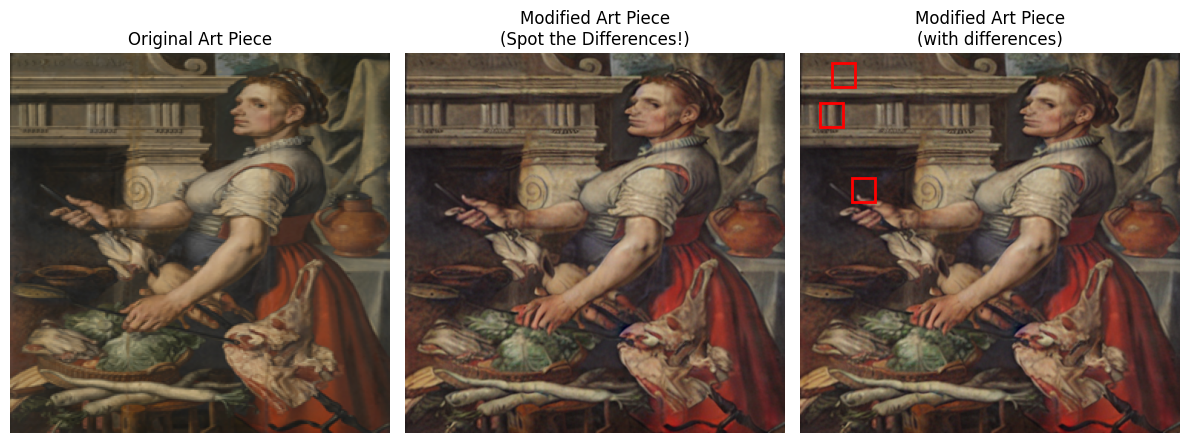

: 

In [38]:
# Print the coordinates of the modified regions.
print("Modified regions (x, y, width, height):")
for diff in differences:
    print(diff)

# Display the original and modified images side by side.
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.title("Original Art Piece")
plt.imshow(original_image)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Modified Art Piece\n(Spot the Differences!)")
plt.imshow(modified_image)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Modified Art Piece\n(with differences)")
plt.imshow(modified_image)
for diff in differences:
    x, y, width, height = diff
    plt.gca().add_patch(plt.Rectangle((x, y), width, height, linewidth=2, edgecolor="r", facecolor="none"))
plt.axis("off")

plt.tight_layout()
plt.show()